## the code we wrote for creating the data.
## https://github.com/anryabrahamyan/Road_Traffic_Prediction/

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import kpss,adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
import pmdarima as pm
import numpy as np
from datetime import timedelta 

In [32]:
df = pd.read_csv("../dataset/data.csv")
df.datetime = pd.to_datetime(df.datetime,format = "%d/%m/%Y %H:%M:%S")
df.index = df.datetime
df.drop(columns = ['datetime'], inplace = True)
df.head()

,weather_main,weather_desc,temp,feels_like,temp_min,temp_max,pressure,humidity,visibility,wind_speed,...,Motorcycle_0.9,Motorcycle_0.7,Motorcycle_0.5,Motorcycle_0.3,Motorcycle_0.1,Ambulance_0.9,Ambulance_0.7,Ambulance_0.5,Ambulance_0.3,Ambulance_0.1
datetime,,,,,,,,,,,,,,,,,,,,,
2022-04-10 20:44:39,Clouds,broken clouds,8.60,3.60,7.31,10.04,1008,47,10000,13.89,...,0,0,0,0,0,0,0,0,0,0
2022-04-10 20:49:39,Clouds,broken clouds,8.60,3.60,7.31,10.04,1008,47,10000,13.89,...,0,0,0,0,0,0,0,0,0,0
2022-04-10 20:54:39,Clouds,overcast clouds,8.68,5.07,7.22,10.13,1008,49,10000,7.60,...,0,0,0,0,0,0,0,0,0,0
2022-04-10 20:59:39,Clouds,overcast clouds,8.68,5.07,7.22,10.13,1008,49,10000,7.60,...,0,0,0,0,0,0,0,0,0,0
2022-04-10 21:04:39,Clouds,overcast clouds,8.68,5.07,7.22,10.13,1008,49,10000,7.60,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df = df.replace("None", np.nan) 
df.iloc[72:144,45] = np.nan

In [34]:
df_cleaned =pd.DataFrame( index=pd.date_range(df.index.min(),df.index.max(),freq='min'))
df_cleaned.index = df_cleaned.index.round(freq='min')
df.index = df.index.round(freq='min')
df_without_na = df[~df['Vehicle_0.1'].isna()]
df_cleaned['Vehicle_0.1'] = np.nan
df_cleaned.loc[df_without_na.index,'Vehicle_0.1']=df_without_na['Vehicle_0.1']

In [35]:
df_cleaned.fillna(method = 'ffill',inplace=True)

In [6]:
# df_cleaned['Vehicle_0.1'] = df_cleaned['Vehicle_0.1'].astype(int)
# df_cleaned = df_cleaned.groupby([df_cleaned.index.day,df_cleaned.index.hour]).mean().reset_index()
# df_cleaned.rename({'level_0':'day','hour':'hour'},inplace=True)
# df_cleaned.plot()

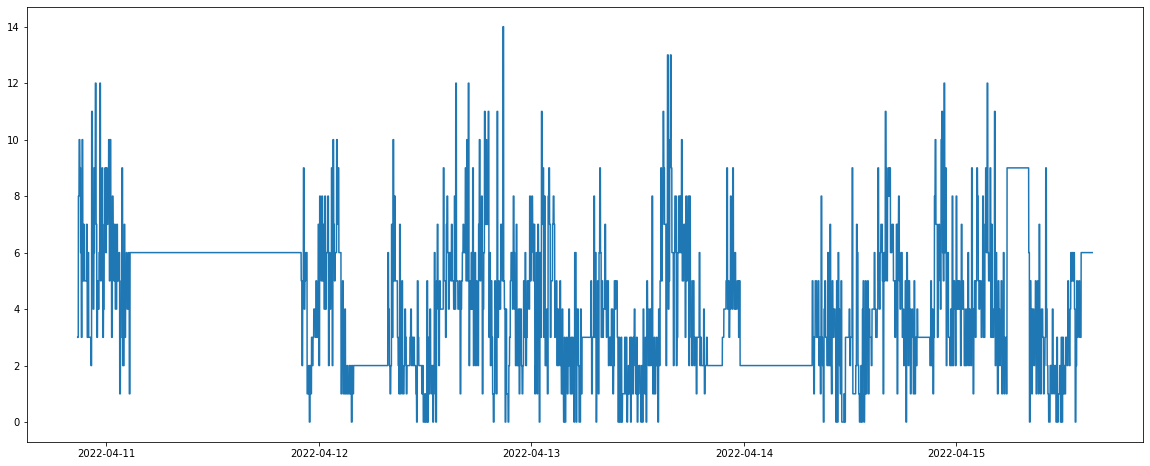

In [36]:
plt.figure(figsize=(20,8))
plt.plot(df_cleaned["Vehicle_0.1"].astype(float))
plt.show()

From the plot we can see that there is no trend, however there is some seasonality because the frequency of the cars decreases after 12am.

In [8]:
X = df_cleaned["Vehicle_0.1"]
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.130831
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


We can see that p value of ADF statistics is almost 0 which is smaller than 0.05, thus we reject the null hypothesis and conclude that our series is stationary.

In [9]:
result = kpss(X)
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('number of lags: %f' % result[2])

print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 2.263453
p-value: 0.010000
number of lags: 35.000000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


We have p-value equal to 0.1, which is larger than 0.05, thus we can say that we have stationary time series.

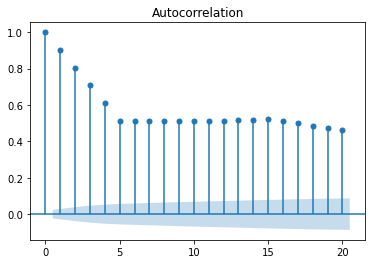

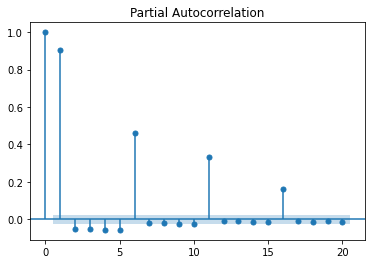

In [10]:
plot_acf(X, lags=20)     
plot_pacf(X, lags=20)     
plt.show()

From the ACF plot we can see that all lags are significant up to lag 20 for the MA process but to reduce the complexity of the model, we will choose lag as 1 for the MA process. In PACF we have significant lags until lag 2 and then cuts off, so we will choose lag as 2.

In [11]:
total_observations = len(X)
train = X[:int(0.8*total_observations)]
test = X[int(0.8*total_observations):]

In [12]:
model = ARIMA(train.astype(float),order=(2, 0, 1)).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: Use

In [13]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:            Vehicle_0.1   No. Observations:                 5500
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -8073.480
Date:                Sun, 17 Apr 2022   AIC                          16156.960
Time:                        11:23:40   BIC                          16190.023
Sample:                    04-10-2022   HQIC                         16168.493
                         - 04-14-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1938      0.164     25.581      0.000       3.872       4.515
ar.L1         -0.0051      0.030     -0.174      0.862      -0.063       0.053
ar.L2          0.8277      0.024     34.607      0.0

In [14]:
predictions = model.forecast(len(test))
residuals = test.astype(float) - predictions

Text(0, 0.5, 'Error')

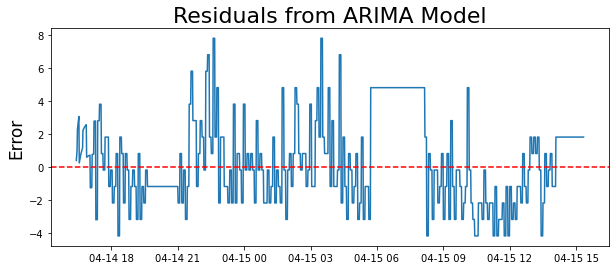

In [15]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='red')
plt.title('Residuals from ARIMA Model', fontsize=22)
plt.ylabel('Error', fontsize=17)

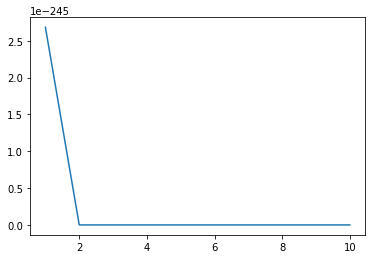

In [16]:
Lj_Box = sm.stats.acorr_ljungbox(residuals, lags = 10,return_df = True)
plt.plot(Lj_Box.index, Lj_Box.lb_pvalue)

We can see that the p-value for different lags is less than 0.05 and almost 0, so we can reject the null hyppthesis, meaning that the errors are not independent.

In [17]:
#WE do not consider the seasonal component because the order of dependence for 1 day is 1440 and it will take forever to fit that model. Further aggregations of the data will help with this problem.
model_auto=pm.auto_arima(
    train,
    test='adf',
    max_p = 12,
    max_d = 1,
    max_q = 12,
    trace=True,
    error_action='ignore', 
    suppress_warnings=True,
    stepwise=True,
    n_fits=120,
    maxiter=11,
    n_jobs=-1)

C:\ProgramData\Anaconda3\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=16134.797, Time=1.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=25461.199, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=16202.366, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=21116.565, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=32984.751, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=16182.386, Time=1.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=16200.805, Time=1.52 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=16119.603, Time=2.01 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=16172.193, Time=1.74 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=15805.490, Time=1.83 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=16178.057, Time=1.67 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=15309.332, Time=1.78 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=15785.558, Time=1.83 sec
 ARIMA(6,0,2)(0,0,0)[0] intercept   : AIC=14840.144, Time=2.45 sec
 ARIMA(6,0,1)(0,0,0

In [18]:
print('MSE of the AUTOARIMA model is', np.mean((model_auto.predict(len(test))-test.astype("float"))**2))

MSE of the AUTOARIMA model is 8.472889017591974


In [19]:
print('MSE of the previously chosen model is', np.mean((model.forecast(len(test)) - test.astype("float")) **2))

MSE of the previously chosen model is 7.332173816115485


We can observe that the MSE of the previously chosen model is lower, meaning that it is better if we take into consideration MSEs.

In [20]:
model = ARIMA(X.astype(float),order=(5,0,1)).fit()
predictions = model.forecast(1440)#24 hours

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'


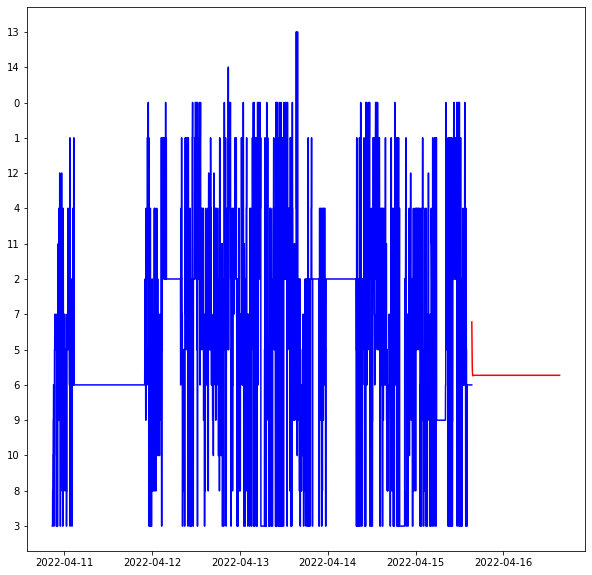

In [21]:
fig = plt.figure(figsize = (10,10))
plt.plot(X,'blue')
plt.plot(predictions,c='red')
plt.show()

In [22]:
exp_smooth = ExponentialSmoothing(train.astype(float),trend=None, seasonal = 'add',initialization_method='estimated',seasonal_periods=120).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


## Car traffic is generally stationary in terms of trend, and the seasonality is additive because the variance is not increasing over time.

In [23]:
predictions = exp_smooth.forecast(len(test))
print('MSE of the exp_smoothing model is', np.mean((predictions.values-test.astype("float"))**2))

MSE of the exp_smoothing model is 19.124268177291103


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


## The exponential smoothing model is worse than the Arima model from before.

In [24]:
exp_smooth = ExponentialSmoothing(df_cleaned.astype(float),trend=None, seasonal = 'add',initialization_method='estimated',seasonal_periods=120).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


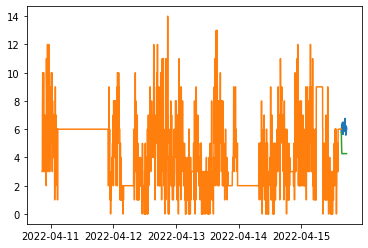

In [25]:
ax = plt.subplot()
ax.plot(exp_smooth.forecast(120))
ax.plot(df_cleaned.astype(float))
ax.plot(model.forecast(120))
plt.show()